<a href="https://colab.research.google.com/github/TuragDev/ML-Python-Codes/blob/main/FVM_Navier_Stokes_Solver.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['animation.html'] = 'html5'
import time

In [ ]:
# grid and domain properties
nx = 16
ny = 16
nu= 0.01
lx =1
ly = 1
dx = lx/nx
dy = ly/ny
# top wall is at a fixed velocity and all other walls are stationary
Ut = 2.0    # m/s, top wall velocity
Ub = 0     # m/s, bottom wall velocity
Vl = 0       # m/s, left wall velocity
Vr = 0       # m/s, left wall velocity
 # Checking Reynolds number
print('Reynolds number = ', Ut*lx/ν)
#Choosing time step size based on advection-diffusion stability criteria using stability condition
#Rule 1:
dt1 = 0.5/ν/(1/dx/dx + 1/dy/dy)
#Rule 2:
dt2 = 2*ν/(Ut**2)
dt = min(dt1,dt2)
print(dt)
#creating the arrays for storing variables
p = np.zeros((ny+2, nx+2))
u = np.zeros((ny+2, nx+2))
v = np.zeros((ny+2, nx+2))
ut = np.zeros_like(u)
vt = np.zeros_like(v)
divut = np.zeros((ny+2, nx+2))

Reynolds number =  200.0
0.005


In [ ]:
#Poisson SOR Solver
Ap = np.zeros((ny+2, nx+2))
Ae = 1/dx/dx*np.ones((ny+2, nx+2))
Aw = 1/dx/dx*np.ones((ny+2, nx+2))
An = 1/dy/dy*np.ones((ny+2, nx+2))
As = 1/dy/dy*np.ones((ny+2, nx+2))
#Left wall coefficient arrays Aw = 0
Aw[1:-1,1] = 0
#right wall coefficient arrays Ae = 0
Ae[1:-1,-2] = 0
#Top wall coefficient arrays An = 0
An[-2, 1:-1] = 0
#Bottom wall coefficient arrays As = 0
As[1, 1:-1] = 0
Ap = - (Ae + Aw + An + As)

def sor_solver(p, S, dx, dy):
    Pk = np.empty_like(p)
    it = 0
    err = 1e10
    tol = 1e-8
    maxit = 10000
    β = 1.25

    while err > tol and it < maxit:
        Pk = p.copy()
        for i in range(1, ny+1):
            for j in range(1, nx+1):
                ap = Ap[j, i]
                ae = Ae[j, i]
                aw = Aw[j, i]
                an = An[j, i]
                as_ = As[j, i]
                pe = p[j, i+1]
                pw = p[j, i-1]
                pn = p[j+1, i]
                ps = p[j-1, i]
                result = S[j, i] - (ae*pe + aw*pw + an*pn + as_*ps)
                p[j, i] = β*result/ap + (1 - β)*Pk[j, i]
        err = np.linalg.norm(p.ravel() - Pk.ravel(), 2)
        it += 1

    print('Poisson solver error: ', err, 'iterations: ', it)
    return p, err

Poisson solver error:  9.79060915075053e-09 iterations:  457
Poisson solver error:  1.959380120354856e-06 iterations:  10000
Poisson solver error:  1.8421246835553914e-06 iterations:  10000
Poisson solver error:  1.719652028721151e-06 iterations:  10000
Poisson solver error:  1.66526643545112e-06 iterations:  10000
Poisson solver error:  1.6319146141086092e-06 iterations:  10000
Poisson solver error:  1.6054064211024023e-06 iterations:  10000
Poisson solver error:  1.5842906352098044e-06 iterations:  10000
Poisson solver error:  1.5688069688573735e-06 iterations:  10000
Poisson solver error:  1.5587785620238526e-06 iterations:  10000


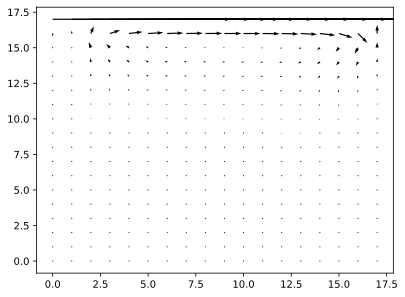

In [ ]:
t = 0.0
tend = 1.0
nsteps = 10

for n in range(0, nsteps):
    # Boundary conditions on the u-velocity
    u[:,1] = 0                   # Left wall, impermeable
    u[:,-1] = 0                  # Right wall, impermeable
    u[-1,:] = 2.0*Ut - u[-2,:]   # Top wall: ughost = 2*Ut – interior
    u[0,:] = 2.0*Ub - u[1,:]     # Bottom wall: ughost = 2*Ub – interior

    # Boundary conditions on the v-velocity
    v[-1, :] = 0                 # Top wall, impermeable
    v[0, :] = 0                  # Bottom wall, impermeable
    v[:, 0] = 2.0*Vl - v[:, 1]   # Left wall: Vghost = 2*Vl – interior
    v[:, -1] = 2.0*Vr - v[:,-2]  # Right wall: Vghost = 2*Vr – interior

    # X-Momentum Equation
    for i in range(2, nx+1):
        for j in range(1, ny+1):
            ue = 0.5*(u[j,i+1]+u[j,i])
            uw = 0.5*(u[j,i-1]+u[j,i])
            un = 0.5*(u[j+1,i]+u[j,i])
            us = 0.5*(u[j-1,i]+u[j,i])
            vn = 0.5*(v[j+1,i-1]+v[j+1,i])
            vs = 0.5*(v[j,i-1]+u[j,i])
            convection = - (ue*ue - uw*uw)/dx - (un*vn - us*vs)/dy
            diffusion = nu * ((u[j,i-1]-2*u[j,i]+u[j,i+1])/dx/dx + (u[j-1,i]-2*u[j,i]+u[j+1,i])/dy/dy)
            ut[j,i] = u[j,i] + dt*(convection + diffusion)

    # Y-Momentum Equation
    for i in range(2, nx+1):
        for j in range(1, ny+1):
            ve = 0.5*(v[j,i+1]+v[j,i])
            vw = 0.5*(v[j,i-1]+v[j,i])
            vn = 0.5*(v[j+1,i]+v[j,i])
            vs = 0.5*(u[j-1,i]+u[j,i])
            ue = 0.5*(u[j,i+1]+v[j-1,i+1])
            uw = 0.5*(u[j,i]+u[j-1,i])
            convection = - (ue*ve - uw*vw)/dx - (vn*vn - vs*vs)/dy
            diffusion = nu * ((v[j,i-1]-2*v[j,i]+v[j,i+1])/dx/dx + (v[j-1,i]-2*v[j,i]+v[j+1,i])/dy/dy)
            vt[j,i] = v[j,i] + dt*(convection + diffusion)

    #divut = dut/x + dvt/dy
    divut[1:-1,1:-1] = (ut[1:-1,2:] - ut[1:-1,1:-1])/dx + (vt[2:, 1:-1] - vt[1:-1,1:-1])/dy
    prsh = divut/dt

    p, err = sor_solver(p, prsh, dx, dy)
    u[1:-1,2:-1] = ut[1:-1, 2:-1] - dt*(p[1:-1, 2:-1] - p[1:-1, 1:-2])/dx
    v[2:-1,1:-1] = vt[2:-1, 1:-1] - dt*(p[2:-1, 1:-1] - p[1:-2, 1:-1])/dy
    t += dt

plt.quiver(u, v)

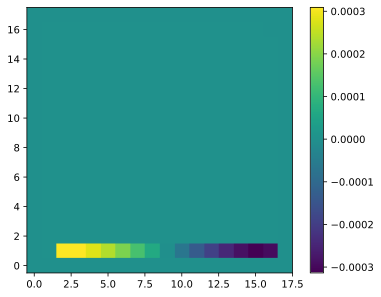

In [ ]:
#computing dilatation
divu = np.zeros_like(p)
for j in range(1, ny+1):
    for i in range(1, nx+1):
        divu[j,i] = (u[j,i+1] - u[j,i])/dx + (v[j+1,i] - v[j,i])/dy
plt.imshow(divu,origin='lower')
plt.colorbar()